In [9]:
from TopoAnalysis import dem as d
import matplotlib.pylab as plt
from TopoAnalysis.plotting import plot_recursive_upstream_profiles
import numpy as np
import os

In [15]:
new_directory_path = "/Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver"  # Replace with your actual path
os.chdir(new_directory_path)
print("New working directory:", os.getcwd())

New working directory: /Users/Glong1/Desktop/Andes/Andes_watersheds/RapelRiver


In [16]:
outlets = {'rapel': {'RP-S2': [246233.51, 6240449.46],
                    'RP-S3': [250637.710, 6228479.760],
                    'RP-S3u': [250129.41, 6237907.31],
                    'RP-S4u': [262282.00, 6217862.57]}
          }

In [18]:
dem = d.Elevation.load('rapel_dem_utm.tif')
filled = d.Elevation.load('rapel_dem_utm_filled')
area = d.Area.load('rapel_area_utm')
fd = d.FlowDirectionD8(flooded_dem = filled)

In [ ]:
dem.plot(interactive = False)

In [19]:
# fixes problem with ld_item added an extra index on the data
def fix_indices_recursive(ld_item):
    """Fix malformed indices recursively"""
    if isinstance(ld_item['index'], tuple) and len(ld_item['index']) == 1:
        ld_item['index'] = ld_item['index'][0]
    
    if ld_item.get('next'):
        for next_item in ld_item['next']:
            fix_indices_recursive(next_item)

def plot_upstream_profile(ld_list, minimum_area=1E5):
    """Plot upstream profile with fixed indices using the exact same logic as original"""
    def plot_recursive(current_distance, ld_item):
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance increment (same logic as original)
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    if (current_row != next_row) & (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414
                    else:
                        distance_increment = ld_item['de']
                    
                    next_distance = current_distance - distance_increment  # upstream direction
                    
                    # Plot the line segment (same as original)
                    plt.plot([current_distance, next_distance], 
                           [ld_item['elevation'], next_item['elevation']], 
                           'k-')
                    
                    # Recurse
                    plot_recursive(next_distance, next_item)
    
    plot_recursive(0.0, ld_list)

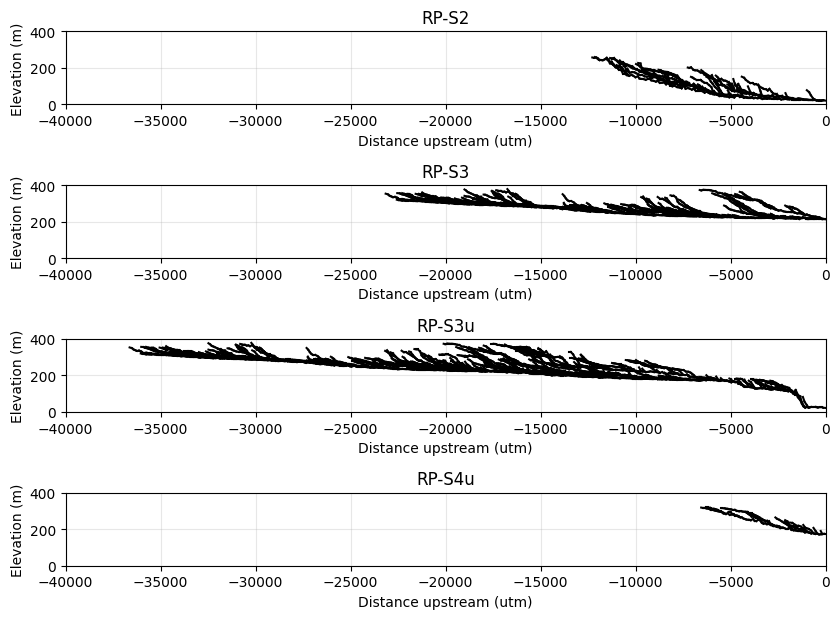

In [20]:
# Create figure
fig, axs = plt.subplots(4)
fig.set_size_inches(8.5,6.3)

mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

counter = 0
for key in outlets['rapel']:
    plt.sca(axs[counter])
    outlet = outlets['rapel'][key]
    
    # Get the data and fix the indices
    ld_list = fd.map_values_to_recursive_list(outlet, elevation=dem, area=area, de=mean_pixel_dimension)
    fix_indices_recursive(ld_list)
    
    # Plot using our fixed function
    plot_upstream_profile(ld_list, minimum_area=1E5)
    
    # Same scaling and titles as original
    axs[counter].set_xlim([-40000, 0])
    axs[counter].set_ylim([0, 400])
    axs[counter].grid(True, alpha=0.3)
    axs[counter].set_xlabel('Distance upstream (utm)')
    axs[counter].set_ylabel('Elevation (m)')
    plt.title(key)
    counter += 1

plt.tight_layout()
plt.savefig('rapel_profiles.png')

# 3D plots

In [11]:
def extract_3d_profile_data(ld_list, minimum_area=1E5):
    """Extract 3D coordinates for the river profile"""
    distances = []
    elevations = []
    x_coords = []
    y_coords = []
    
    def collect_points(current_distance, ld_item):
        row, col = ld_item['index']
        
        # Convert grid indices to world coordinates (approximate)
        # You might need to adjust this based on your DEM's coordinate system
        x_coord = col * 30  # assuming 30m pixel size, adjust as needed
        y_coord = row * 30  # assuming 30m pixel size, adjust as needed
        
        distances.append(current_distance)
        elevations.append(ld_item['elevation'])
        x_coords.append(x_coord)
        y_coords.append(y_coord)
        
        if ld_item.get('next'):
            for next_item in ld_item['next']:
                if next_item['area'] >= minimum_area:
                    # Calculate distance increment
                    current_row, current_col = ld_item['index']
                    next_row, next_col = next_item['index']
                    
                    if (current_row != next_row) and (current_col != next_col):
                        distance_increment = ld_item['de'] * 1.414  # diagonal
                    else:
                        distance_increment = ld_item['de']  # orthogonal
                    
                    next_distance = current_distance - distance_increment  # upstream (negative)
                    collect_points(next_distance, next_item)
    
    collect_points(0.0, ld_list)
    return np.array(distances), np.array(elevations), np.array(x_coords), np.array(y_coords)

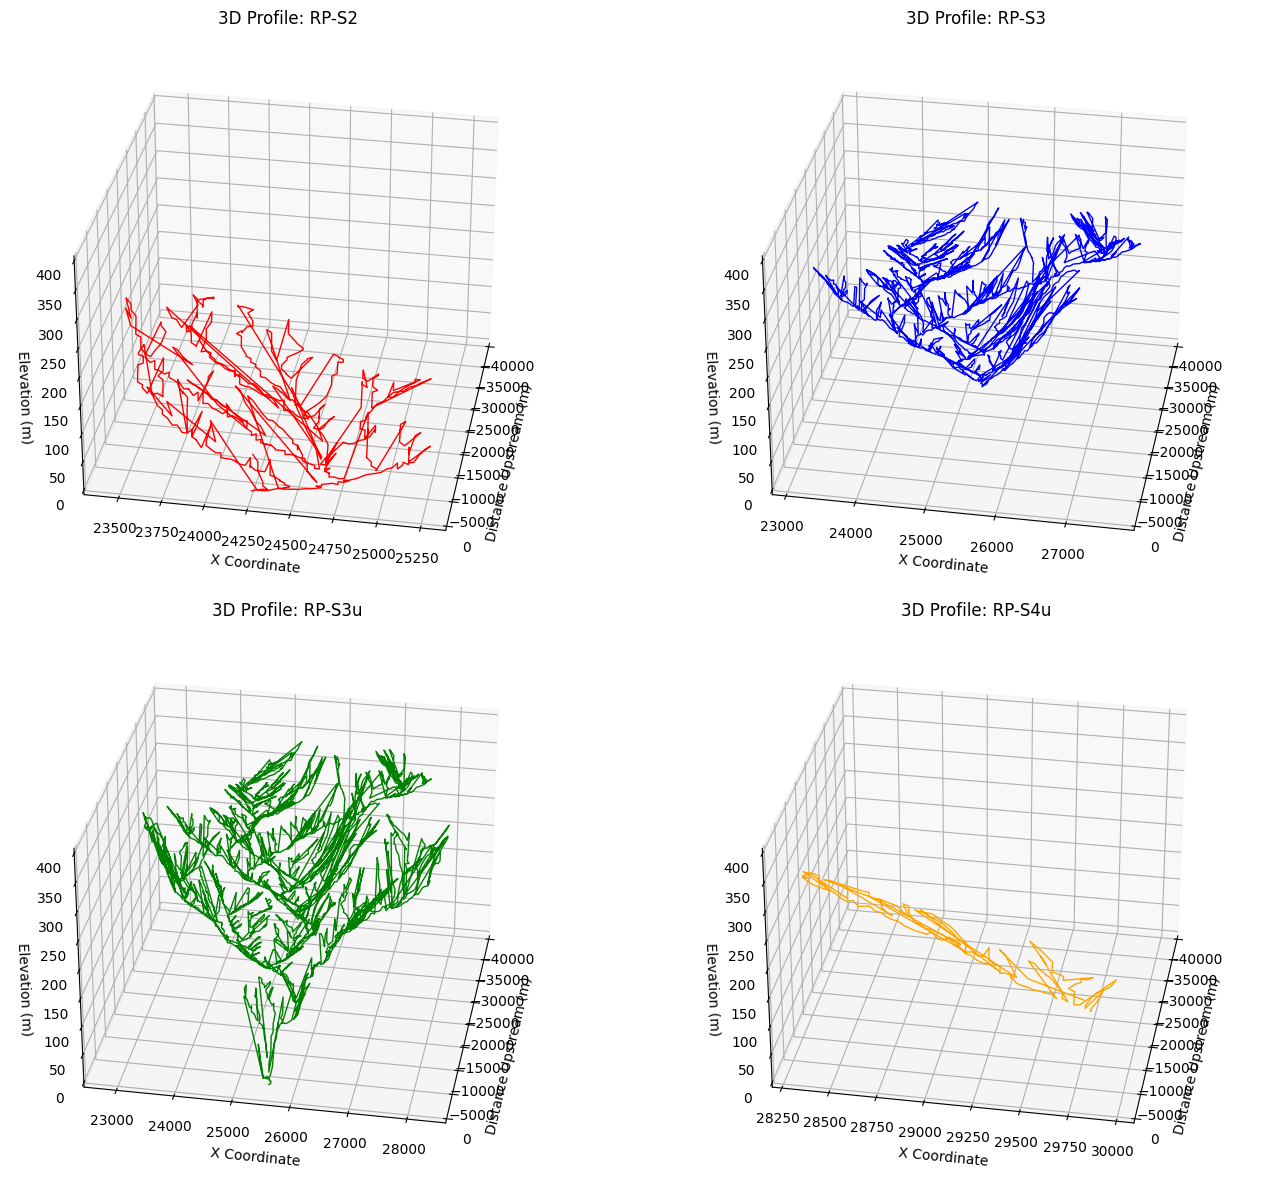

In [12]:
# Create 3D figure
fig = plt.figure(figsize=(15, 12))

# Create subplots: 2x2 grid of 3D plots
colors = ['red', 'blue', 'green', 'orange']
labels = list(outlets['rapel'].keys())

mean_pixel_dimension = d.BaseSpatialGrid()
mean_pixel_dimension._copy_info_from_grid(area, True)
mean_pixel_dimension._griddata = area._mean_pixel_dimension()

# Individual 3D subplots
for i, (key, color) in enumerate(zip(outlets['rapel'], colors)):
    ax = fig.add_subplot(2, 2, i+1, projection='3d')
    ax.view_init(elev=30, azim=10)
    outlet = outlets['rapel'][key]
    # Get the data and fix the indices
    ld_list = fd.map_values_to_recursive_list(outlet, elevation=dem, area=area, de=mean_pixel_dimension)
    fix_indices_recursive(ld_list)
    # Extract 3D data
    distances, elevations, x_coords, y_coords = extract_3d_profile_data(ld_list, minimum_area=1E5)
    
    if len(distances) > 0:
        # Plot the 3D river profile
        ax.plot(distances, x_coords, elevations, color=color, linewidth=1, label=key)
        # Add some styling
        ax.set_xlabel('Distance Upstream (m)')
        ax.set_ylabel('X Coordinate')
        ax.set_zlabel('Elevation (m)')
        ax.set_title(f'3D Profile: {key}')
        # Set consistent limits
        ax.set_xlim([-40000, 0])
        ax.set_zlim([0, 400])
        # Add a grid
        ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.show()